In [1]:
"""
BEFORE RUNNING THIS NOTEOOK, CHANGE RUNTYPE TO GPU! IMPORT FOR EXERCISE 2.
"""

!pip install shap
!pip install -U sentence-transformers
!pip install bertopic
!pip install plotly==5.19.0

import seaborn as sns
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import shap
import torch
shap.initjs()
from xgboost import plot_importance

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
from hdbscan import HDBSCAN
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64

#Exercise 1

## **Small overview of the data**

In [2]:
input_folder_path = '/content/drive/MyDrive/gofundme_zecharies/' #change to what is needed as path for all exercises files

In [5]:

fraud_train = pd.read_csv(input_folder_path + 'fraud_train.csv')
fraud_test = pd.read_csv(input_folder_path + 'fraud_test.csv')
recommendations = pd.read_csv(input_folder_path + 'recommendations.csv')
bonus = pd.read_csv(input_folder_path + 'bonus.csv')

fraud_train_head = fraud_train.head()
fraud_test_head = fraud_test.head()
recommendations_head = recommendations.head()
bonus_head = bonus.head()

fraud_train_info = fraud_train.info()
fraud_test_info = fraud_test.info()
recommendations_info = recommendations.info()
bonus_info = bonus.info()

(fraud_train_head, fraud_test_head, recommendations_head, bonus_head, fraud_train_info, fraud_test_info, recommendations_info, bonus_info)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   fund_id                                                   50000 non-null  int64  
 1   category_id                                               49994 non-null  float64
 2   goal                                                      49994 non-null  float64
 3   descr_len                                                 49993 non-null  float64
 4   title_len                                                 49993 non-null  float64
 5   primary_phone_checks__line_type                           50000 non-null  object 
 6   identity_check_score                                      49703 non-null  float64
 7   primary_email_address_checks__is_disposable               50000 non-null  int64  
 8   primary_email_ad

(    fund_id  category_id     goal  descr_len  title_len  \
 0  62614939         11.0  15000.0     1649.0       47.0   
 1  62694049          3.0   2500.0      214.0       16.0   
 2  60732709         15.0   1500.0      783.0       48.0   
 3  66053789         11.0  10000.0      364.0       28.0   
 4  58261465          4.0   2500.0      353.0       23.0   
 
   primary_phone_checks__line_type  identity_check_score  \
 0                          mobile                  25.0   
 1                          mobile                 448.0   
 2                         unknown                 123.0   
 3                          mobile                  52.0   
 4                          mobile                  19.0   
 
    primary_email_address_checks__is_disposable  \
 0                                            0   
 1                                            0   
 2                                            0   
 3                                            0   
 4                   

In [6]:
fraud_train

,fund_id,category_id,goal,descr_len,title_len,primary_phone_checks__line_type,identity_check_score,primary_email_address_checks__is_disposable,primary_email_address_checks__email_domain_creation_days,label
0,62614939,11.0,15000.0,1649.0,47.0,mobile,25.0,0,9858.0,0
1,62694049,3.0,2500.0,214.0,16.0,mobile,448.0,0,9861.0,0
2,60732709,15.0,1500.0,783.0,48.0,unknown,123.0,0,9567.0,0
3,66053789,11.0,10000.0,364.0,28.0,mobile,52.0,0,10015.0,0
4,58261465,4.0,2500.0,353.0,23.0,mobile,19.0,0,9458.0,0
...,...,...,...,...,...,...,...,...,...,...
49995,59152881,20.0,20000.0,942.0,45.0,mobile,339.0,0,9855.0,1
49996,61544409,11.0,5600.0,735.0,44.0,mobile,405.0,0,9604.0,1
49997,58384529,4.0,8000.0,90.0,26.0,mobile,376.0,0,9464.0,1
49998,60493763,3.0,3500.0,531.0,31.0,mobile,458.0,0,9556.0,1


In [7]:
#checking if target is actually balanced
fraud_train['label'].value_counts() / len(fraud_train)

,count
label,
0,0.5
1,0.5


## **Checking Nulls**

In [8]:
fraud_train[fraud_train['identity_check_score'].isna()].shape

(297, 10)

In [9]:
fraud_train[fraud_train['primary_email_address_checks__email_domain_creation_days'].isna()].shape

(297, 10)

In [10]:
fraud_train[fraud_train['identity_check_score'].isna()
& fraud_train['primary_email_address_checks__email_domain_creation_days'].isna()]

,fund_id,category_id,goal,descr_len,title_len,primary_phone_checks__line_type,identity_check_score,primary_email_address_checks__is_disposable,primary_email_address_checks__email_domain_creation_days,label
137,63645531,9.0,5000.0,265.0,32.0,unknown,NaN,0,NaN,0
161,60060849,2.0,5000.0,277.0,38.0,unknown,NaN,0,NaN,0
169,59489759,15.0,5000.0,2553.0,49.0,unknown,NaN,0,NaN,0
429,59050783,2.0,3500.0,566.0,28.0,unknown,NaN,0,NaN,0
694,58219855,344.0,300.0,567.0,45.0,unknown,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...
46012,64161045,11.0,3000.0,120.0,10.0,unknown,NaN,0,NaN,1
47295,62081421,3.0,6000.0,1067.0,49.0,unknown,NaN,0,NaN,1
47683,60214763,17.0,1000.0,980.0,15.0,unknown,NaN,0,NaN,1
49459,59728041,2.0,4000.0,329.0,20.0,unknown,NaN,0,NaN,1


In [11]:
fraud_train[fraud_train['identity_check_score'].isna()
& fraud_train['primary_email_address_checks__email_domain_creation_days'].isna()]['label'].value_counts()

,count
label,
0,269
1,27


In [12]:
#almost same population for both null columns. interestingly overrepresented by non fraudulent population.
#I will replace for -1 both so that they dont get lost using the average
#other variables have a very low percentage of nulls, so I wont pay special attention to them

In [13]:
fraud_train['primary_email_address_checks__email_domain_creation_days'].fillna(-1, inplace=True)
fraud_train['identity_check_score'].fillna(-1, inplace=True)
fraud_test['primary_email_address_checks__email_domain_creation_days'].fillna(-1, inplace=True)
fraud_test['identity_check_score'].fillna(-1, inplace=True)

## Category_id despite being a int, is a category, so it should be a string to be encoded later

In [14]:
fraud_train['category_id'] = fraud_train['category_id'].astype(str)
fraud_test['category_id'] = fraud_test['category_id'].astype(str)

In [15]:
numeric_features = ['goal', 'descr_len', 'title_len', 'identity_check_score',
                    'primary_email_address_checks__email_domain_creation_days', 'primary_email_address_checks__is_disposable']
categorical_features = ['primary_phone_checks__line_type', 'category_id'] #category id is numeric but has no real numeric magnitud value


In [16]:
fraud_train.dtypes

,0
fund_id,int64
category_id,object
goal,float64
descr_len,float64
title_len,float64
primary_phone_checks__line_type,object
identity_check_score,float64
primary_email_address_checks__is_disposable,int64
primary_email_address_checks__email_domain_creation_days,float64
label,int64


## Lets check correlations

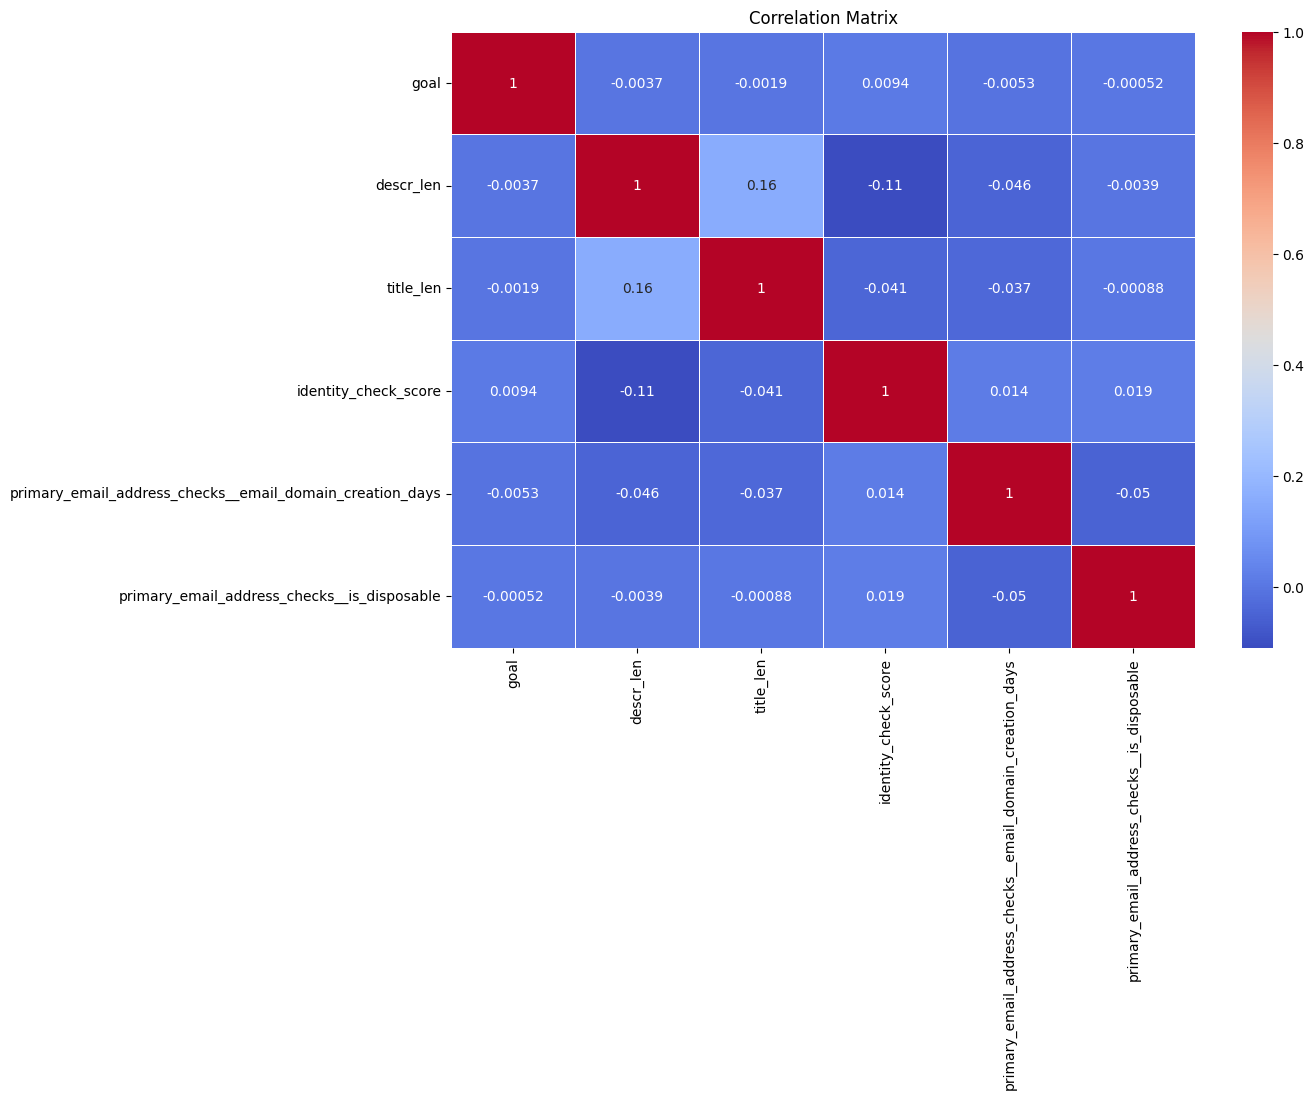

In [17]:
correlation_matrix = fraud_train[numeric_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## No big correlations zoom into

## Let's check outliers

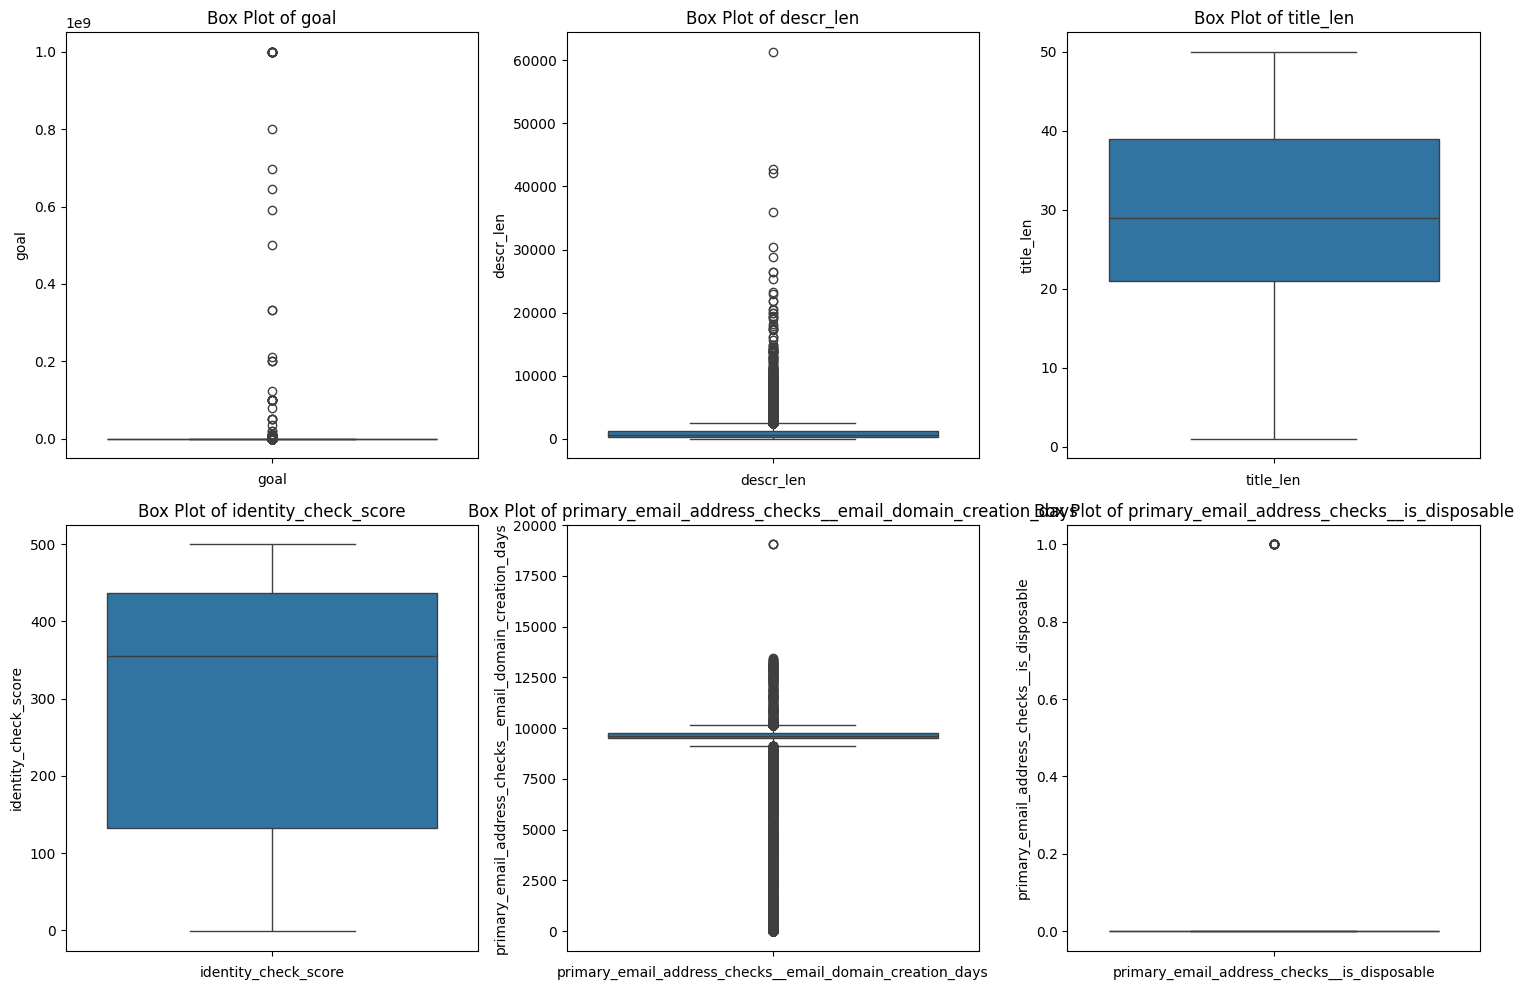

In [18]:
num_features = len(numeric_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 5, num_rows * 5))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(data=fraud_train[feature])
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

## Features goal and descr_len clearly have some outliers, lets cap them at percentile 99 to redo plots and

In [19]:
def cap_at_percentile(column):
    percentile_97 = column.quantile(0.97)
    return column.apply(lambda x: min(x, percentile_97))

# Apply the function to both columns
fraud_train['goal'] = cap_at_percentile(fraud_train['goal'])
fraud_train['descr_len'] = cap_at_percentile(fraud_train['descr_len'])
fraud_test['goal'] = cap_at_percentile(fraud_test['goal'])
fraud_test['descr_len'] = cap_at_percentile(fraud_test['descr_len'])

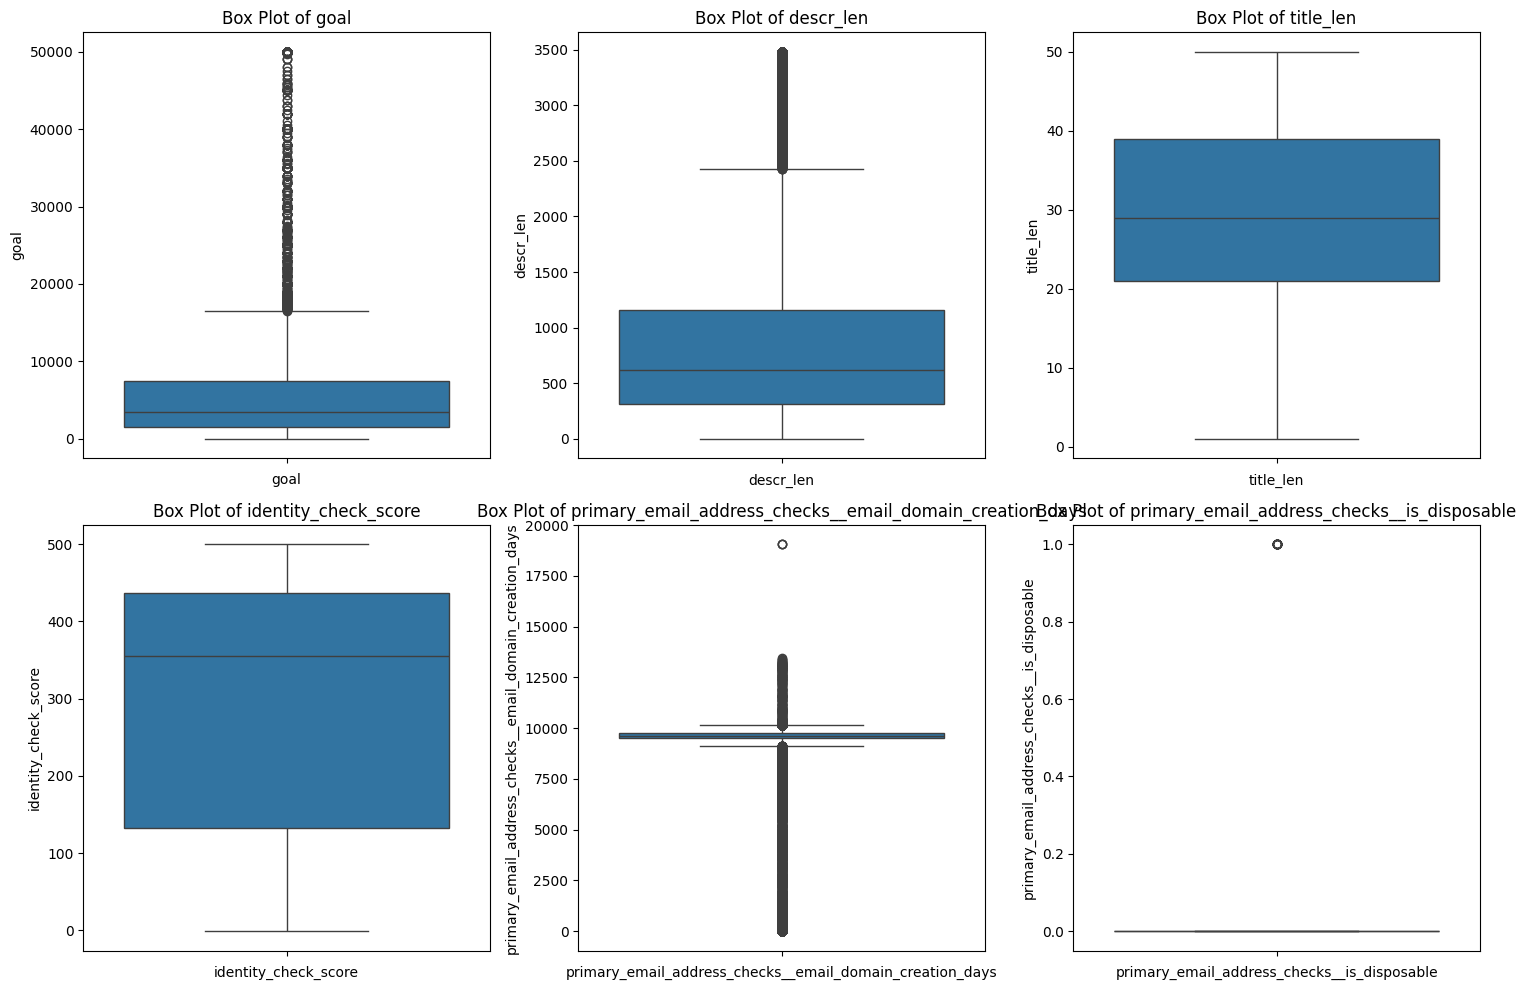

In [20]:
num_features = len(numeric_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 5, num_rows * 5))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(data=fraud_train[feature])
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

## Lets train the model

In [21]:
def preprocess_fraud_data(X):

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # would use ignore in prod but prefer to get error in test
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    return X_preprocessed, preprocessor

#preprocess the training data
X_train = fraud_train.drop(columns=['label', 'fund_id'])
y_train = fraud_train['label']

X_train_preprocessed, preprocessor = preprocess_fraud_data(X_train)

#extract feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

#apply the same preprocessing to the test data
X_test = fraud_test.drop(columns=['label', 'fund_id'])
y_test = fraud_test['label']
X_test_preprocessed = preprocessor.transform(X_test)

xgb = XGBClassifier(random_state=2)

#cross-validation
kf = StratifiedKFold(n_splits=5)
cross_val_accuracy = cross_val_score(xgb, X_train_preprocessed, y_train, cv=kf, scoring='accuracy')

In [23]:
# Train the model on the full training set
xgb.fit(X_train_preprocessed, y_train)

#train predictions
y_train_pred_proba = xgb.predict_proba(X_train_preprocessed)[:, 1]
y_train_pred = xgb.predict(X_train_preprocessed)

#train evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

#test predictions
y_test_pred_proba = xgb.predict_proba(X_test_preprocessed)[:, 1]
y_test_pred = xgb.predict(X_test_preprocessed)

#test evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

results = {
    "Cross-Validation Accuracy": cross_val_accuracy.mean(),
    "Train Accuracy": train_accuracy,
    "Train ROC-AUC": train_roc_auc,
    "Train Precision": train_precision,
    "Train Recall": train_recall,
    "Train F1 Score": train_f1,
    "Test Accuracy": test_accuracy,
    "Test ROC-AUC": test_roc_auc,
    "Test Precision": test_precision,
    "Test Recall": test_recall,
    "Test F1 Score": test_f1
}

for metric, value in results.items():
    print(f"{metric}: {value}")

Cross-Validation Accuracy: 0.8735199999999999
Train Accuracy: 0.91058
Train ROC-AUC: 0.9725292456
Train Precision: 0.9061448977169311
Train Recall: 0.91604
Train F1 Score: 0.911065581922702
Test Accuracy: 0.78012
Test ROC-AUC: 0.8771476459760285
Test Precision: 0.727997924638433
Test Recall: 0.895992975734355
Test F1 Score: 0.8033062582745912


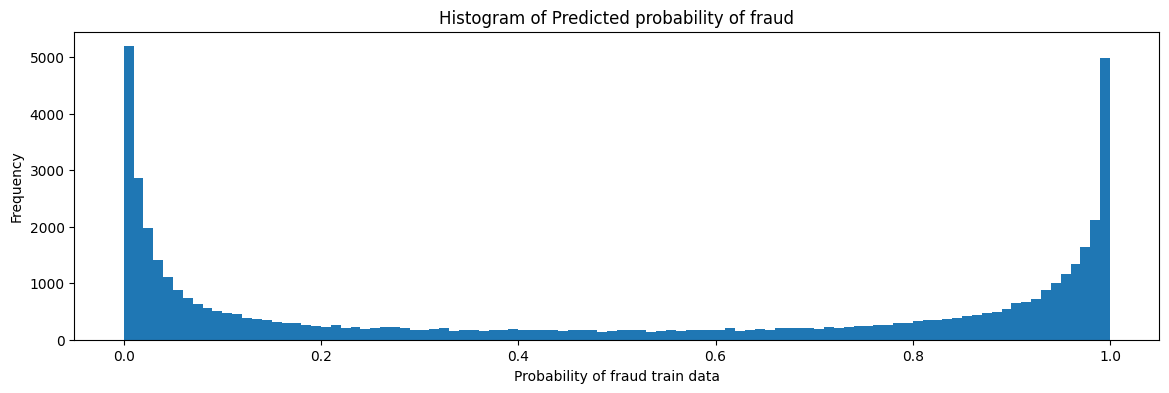

In [24]:
import matplotlib.pyplot as plt
probabilities_df = pd.DataFrame(xgb.predict_proba(X_train_preprocessed))

positive_class_probs = probabilities_df.iloc[:, 1]

positive_class_probs.hist(bins=[i/100.0 for i in range(101)], figsize=(14,4))

plt.xlabel('Probability of fraud train data')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted probability of fraud')
plt.grid(False)
plt.show()

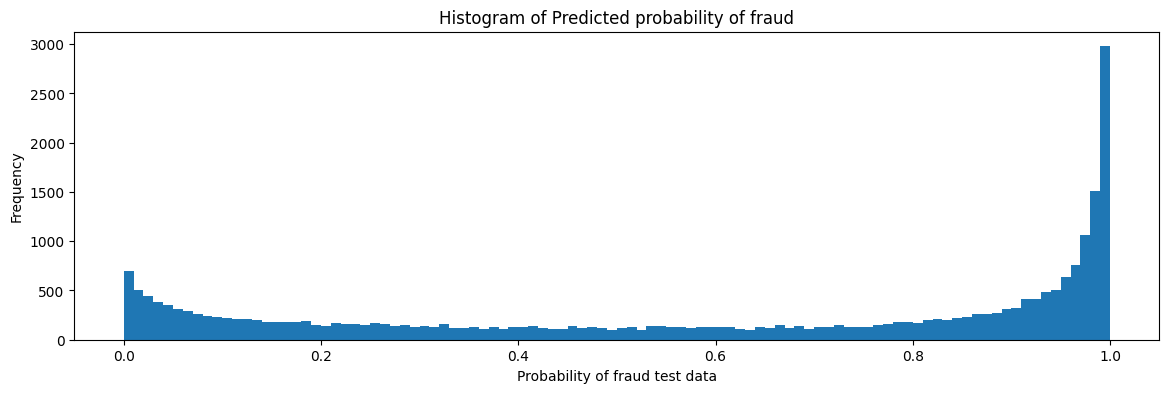

In [25]:
probabilities_df = pd.DataFrame(xgb.predict_proba(X_test_preprocessed))

positive_class_probs = probabilities_df.iloc[:, 1]

positive_class_probs.hist(bins=[i/100.0 for i in range(101)], figsize=(14,4))

plt.xlabel('Probability of fraud test data')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted probability of fraud')
plt.grid(False)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

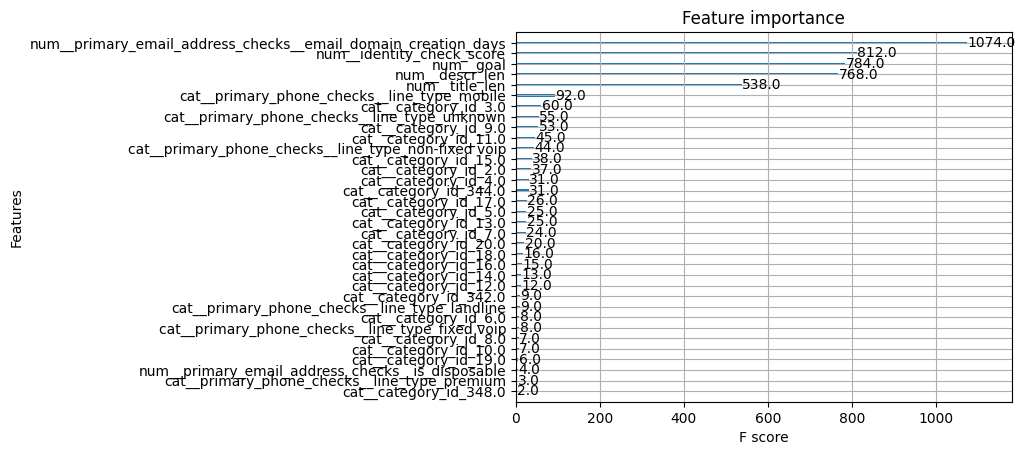

In [27]:
xgb.get_booster().feature_names = list(feature_names)
plot_importance(xgb.get_booster())

## Getting Shap values to interpret the model results

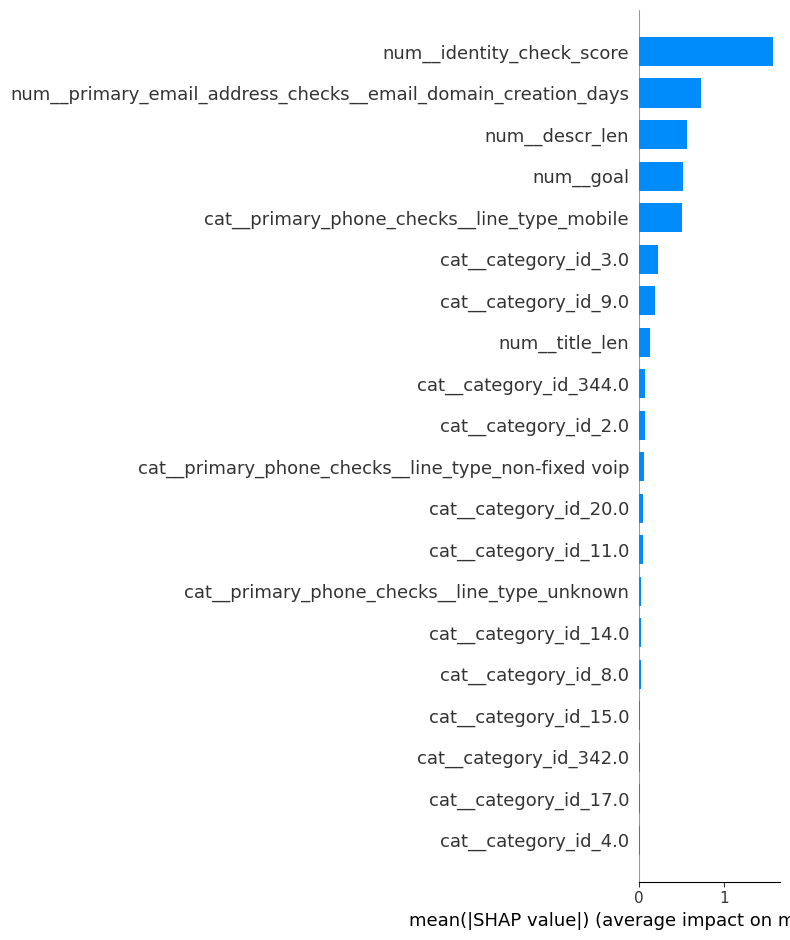

In [28]:
explainer = shap.Explainer(xgb, output_names = feature_names)
shap_values_test = explainer(X_test_preprocessed)
shap_values_test.feature_names = feature_names
shap.summary_plot(shap_values_test, X_test_preprocessed, plot_type="bar")

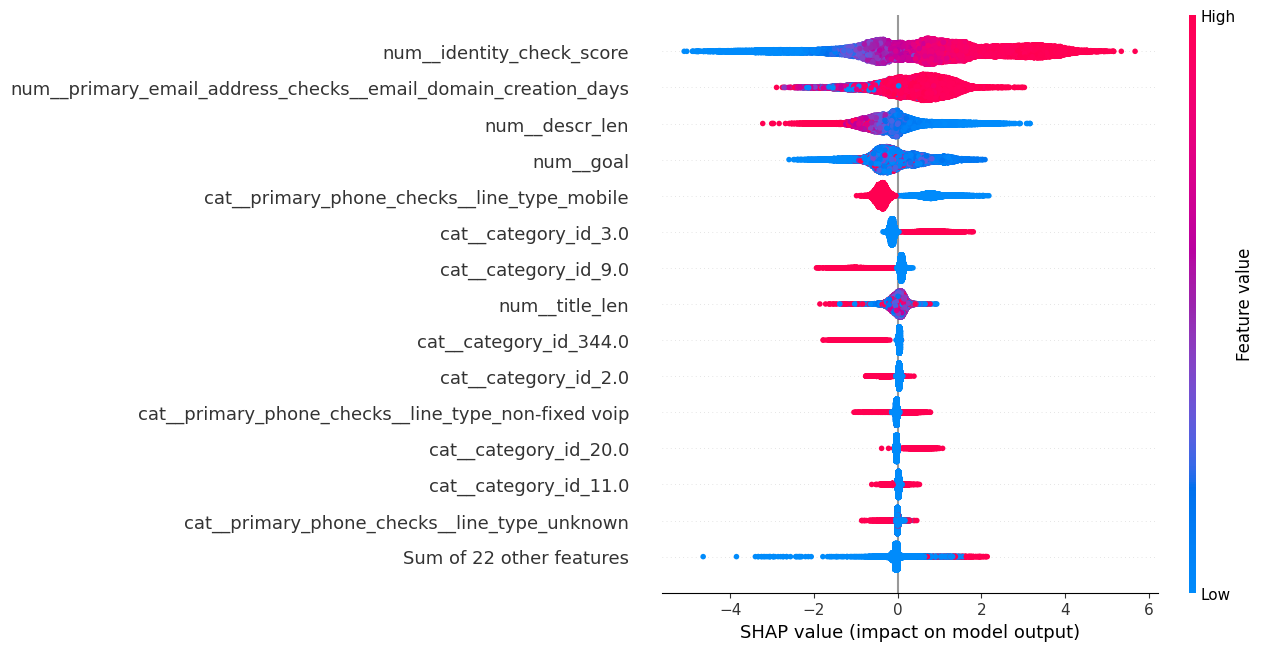

In [29]:
shap.plots.beeswarm(shap_values_test, max_display=15)

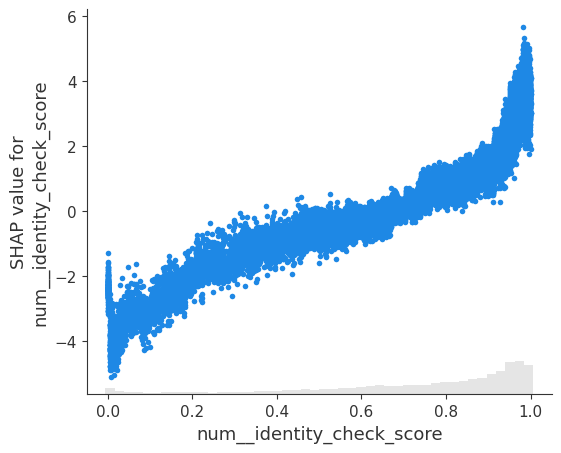

In [30]:
shap.plots.scatter(shap_values_test[:,'num__identity_check_score'])

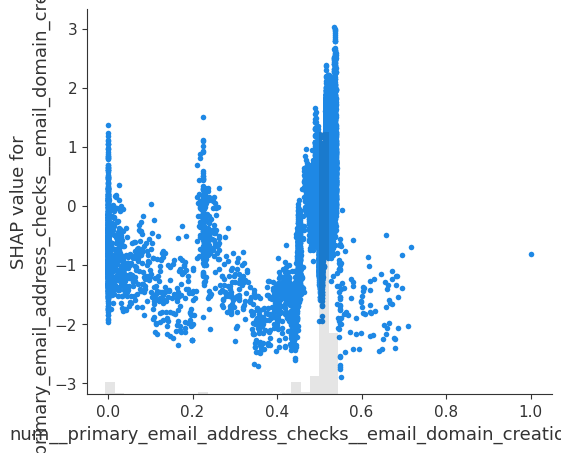

In [31]:
shap.plots.scatter(shap_values_test[:,'num__primary_email_address_checks__email_domain_creation_days'])

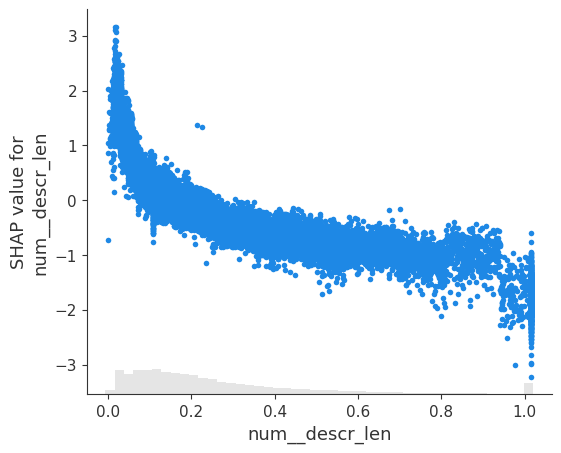

In [32]:
shap.plots.scatter(shap_values_test[:,'num__descr_len'])

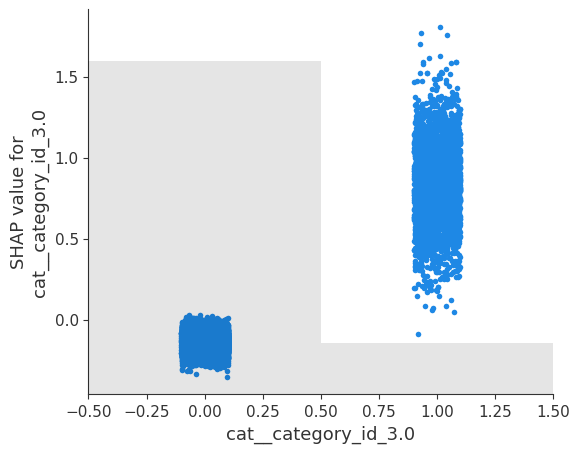

In [33]:
shap.plots.scatter(shap_values_test[:,'cat__category_id_3.0'])

## Getting a better sense of the data for the business stakeholders

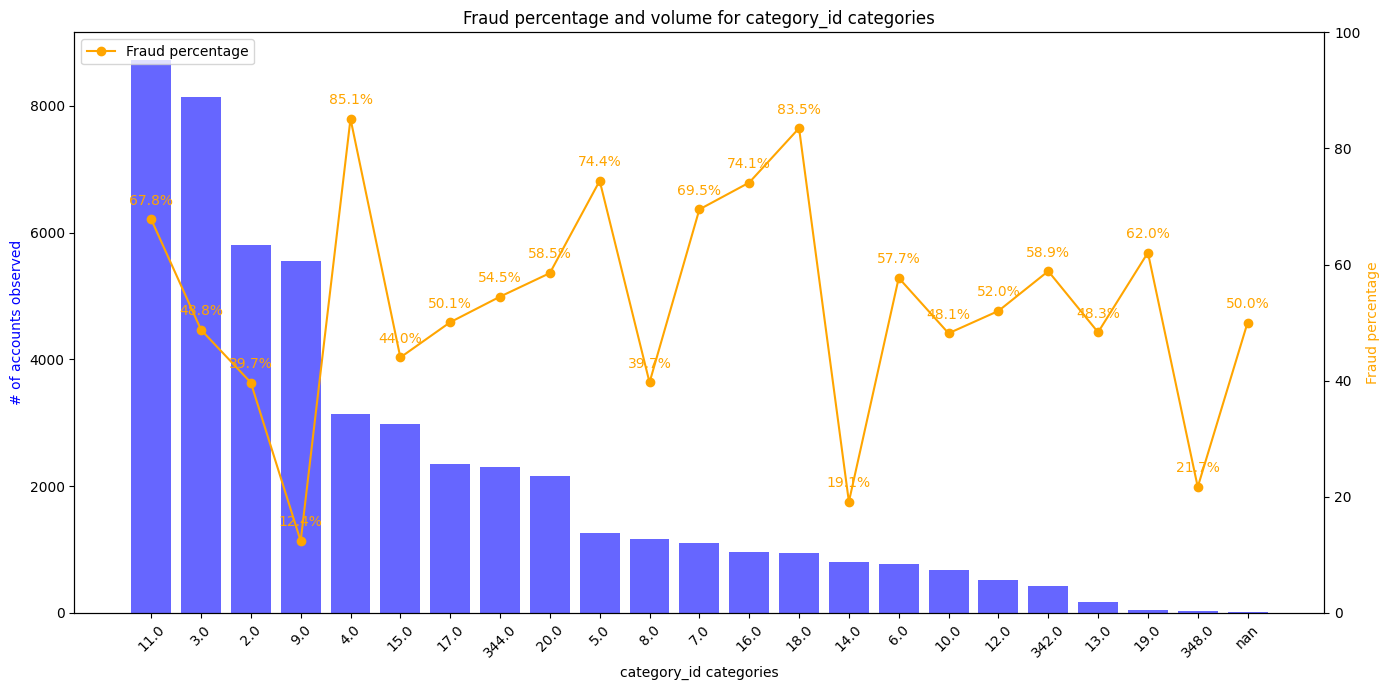

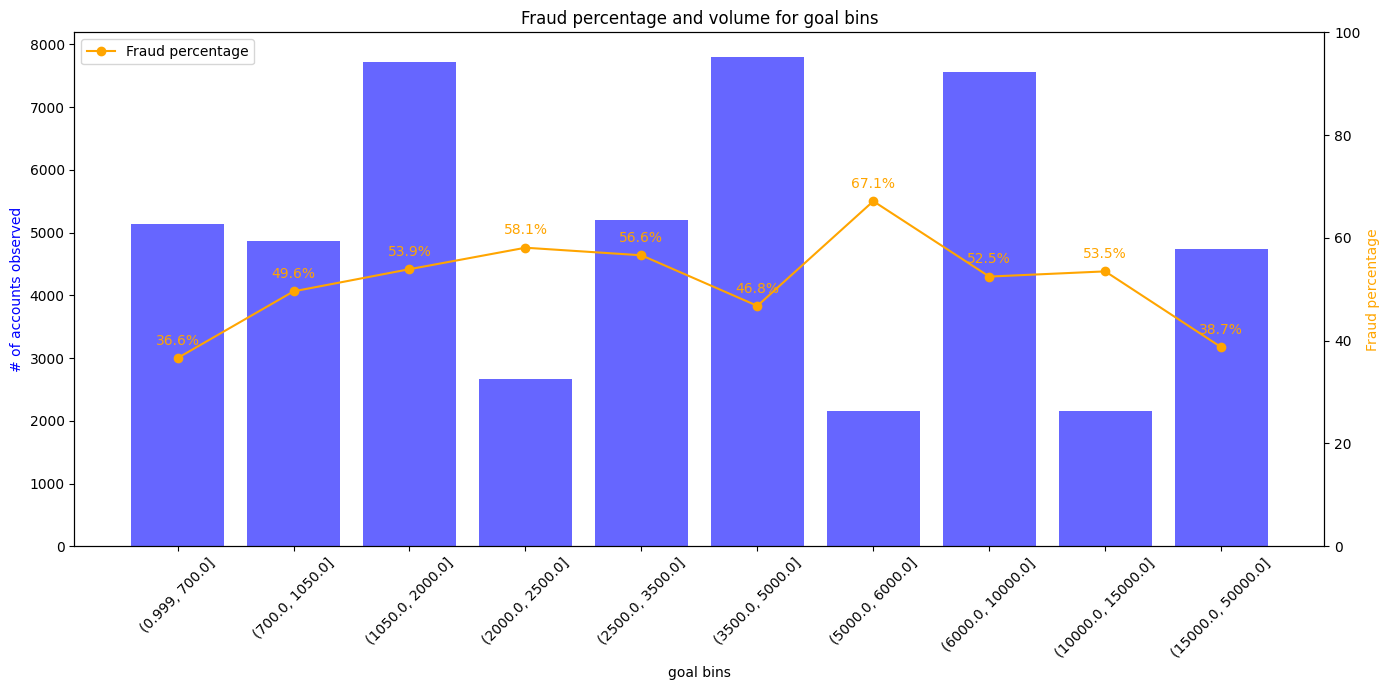

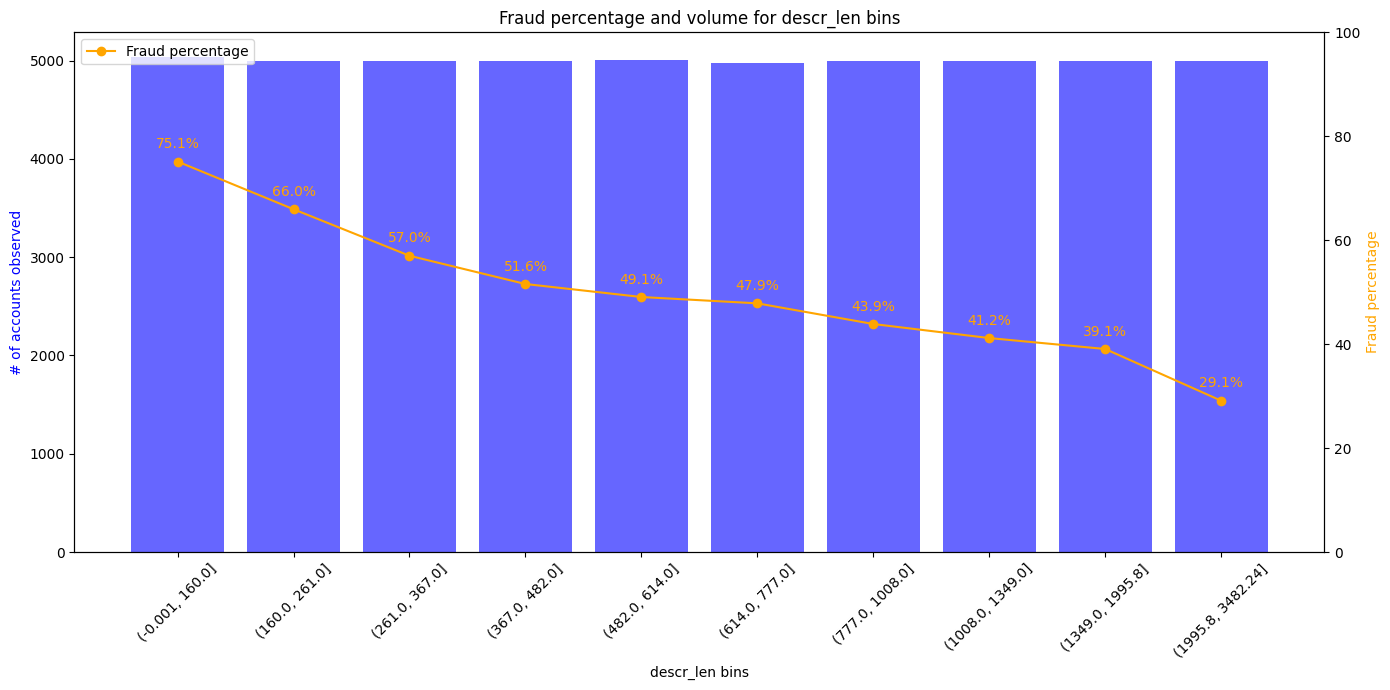

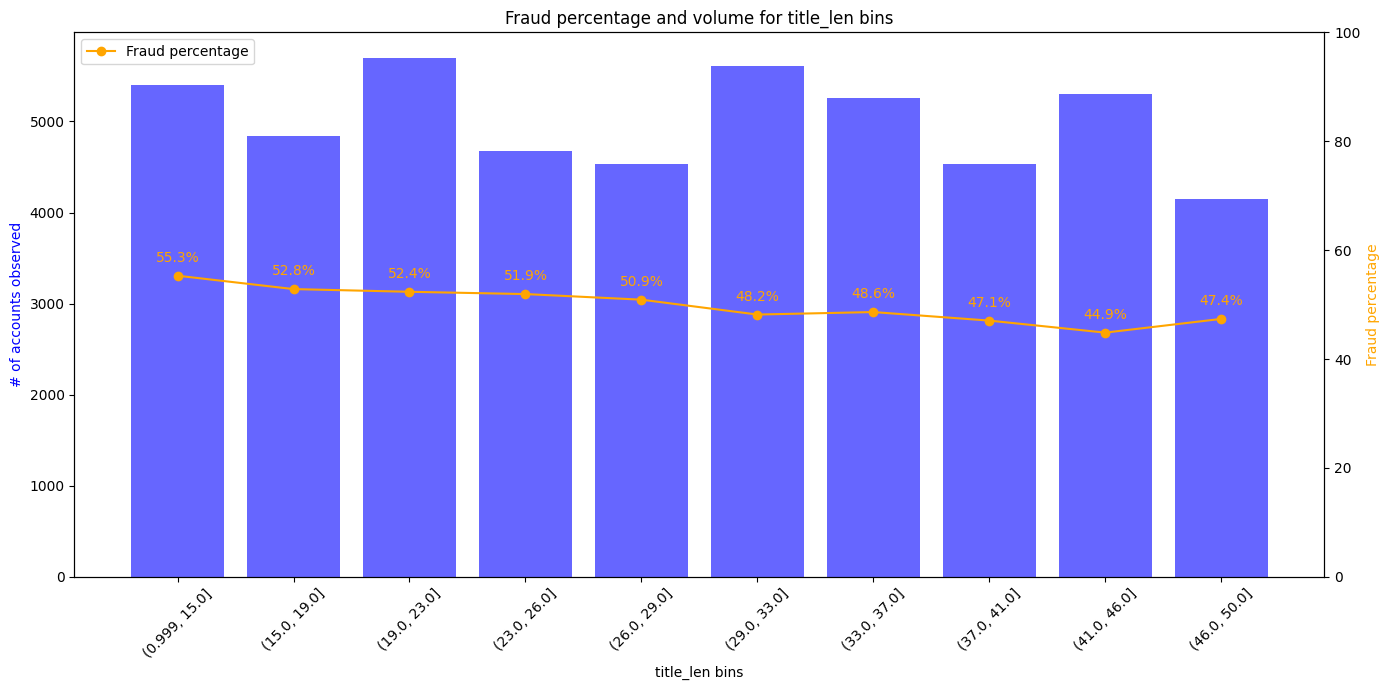

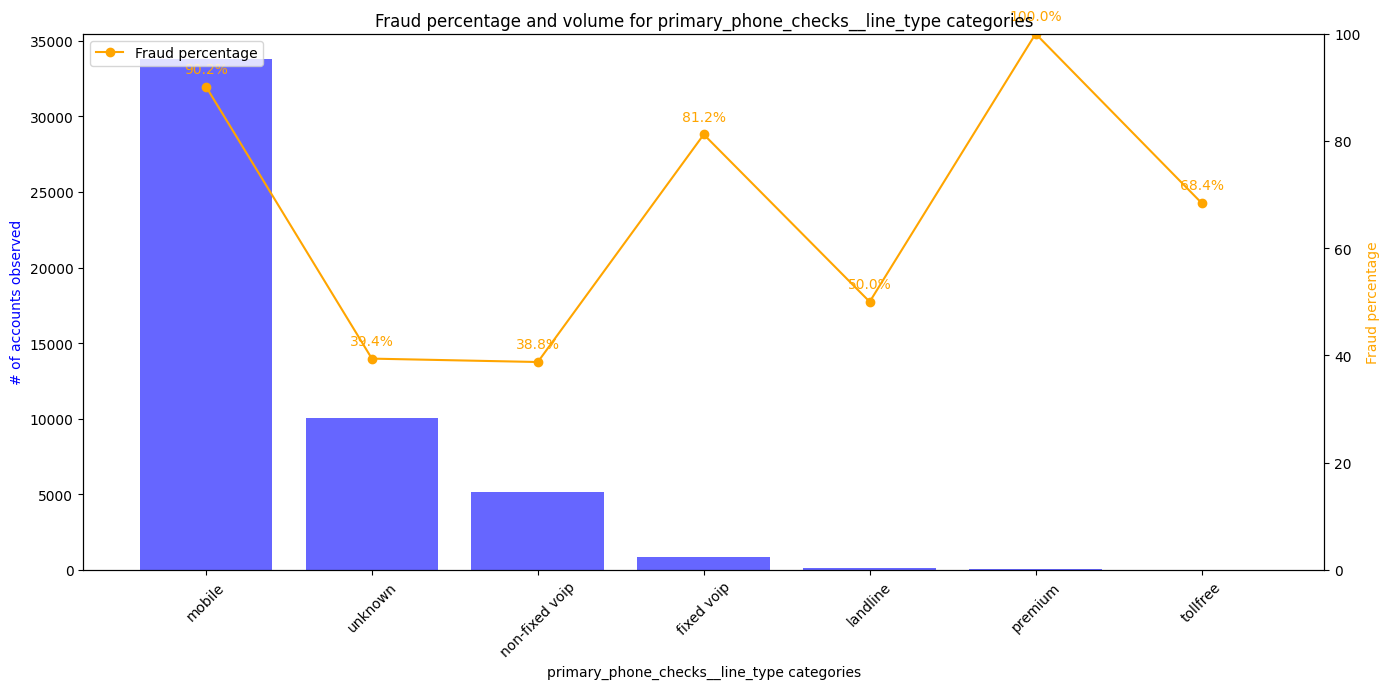

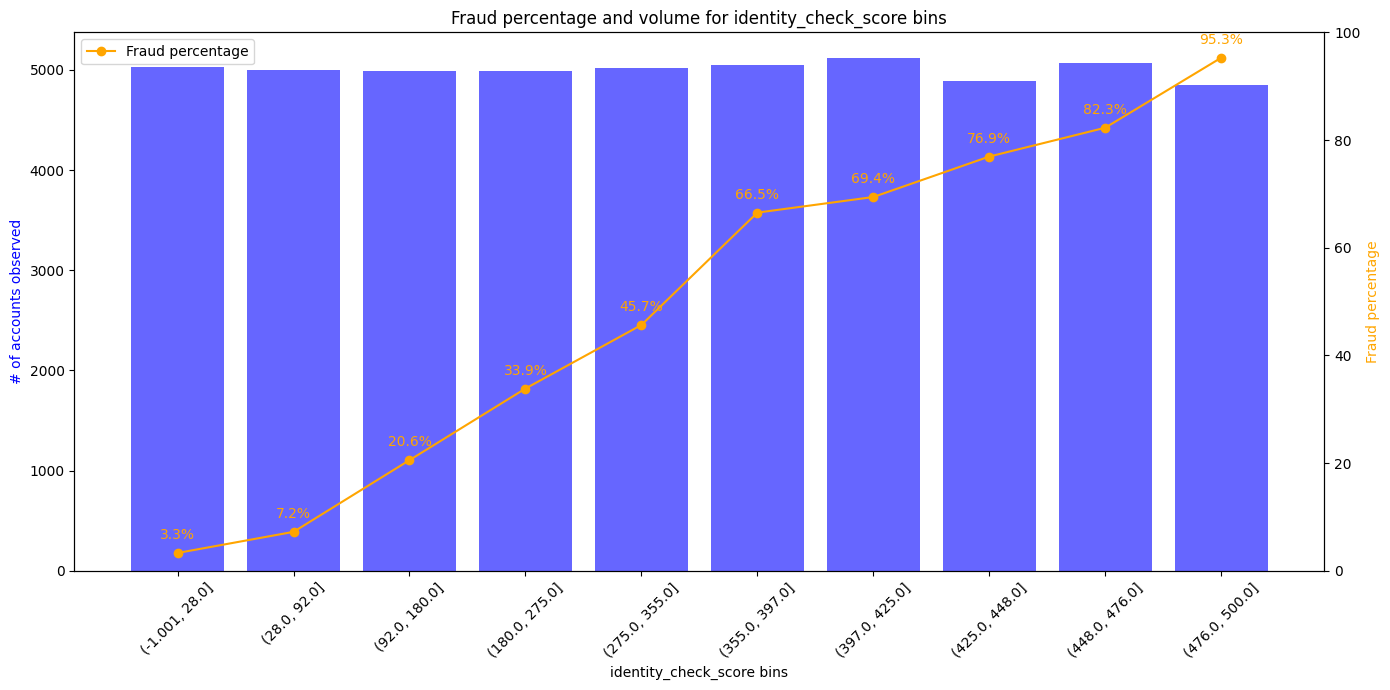

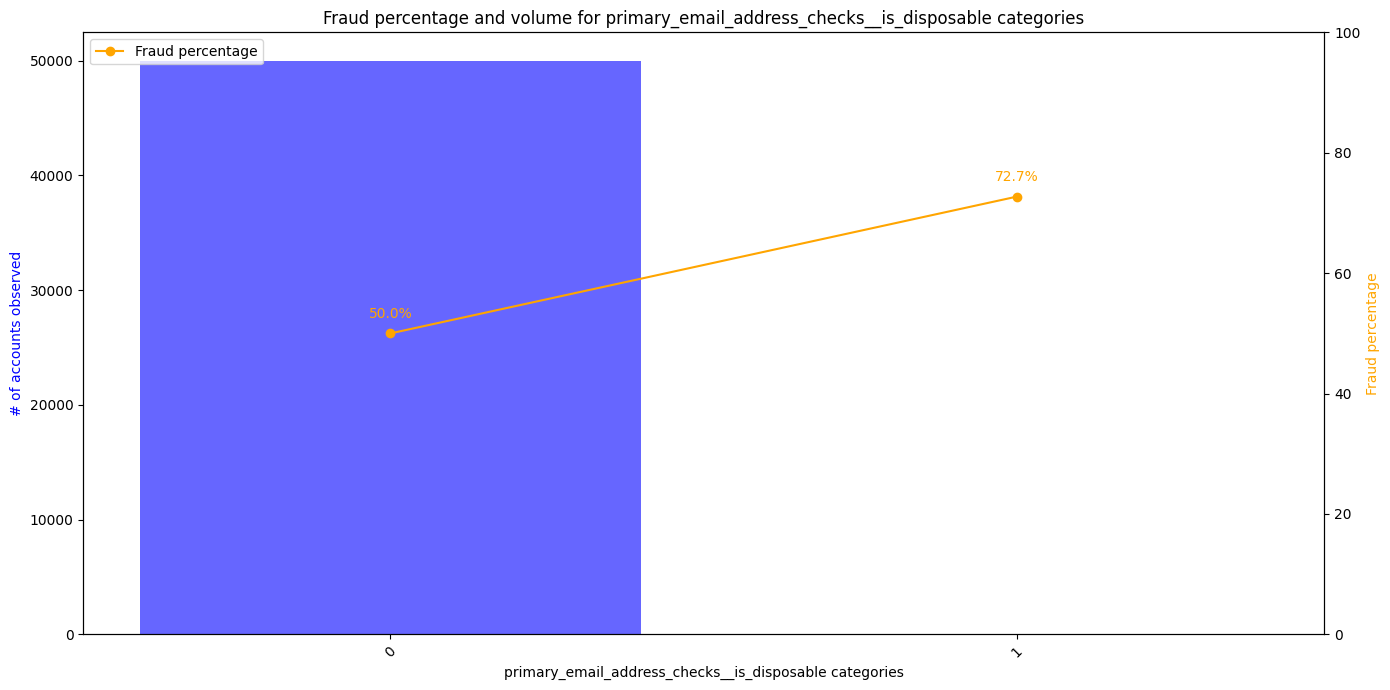

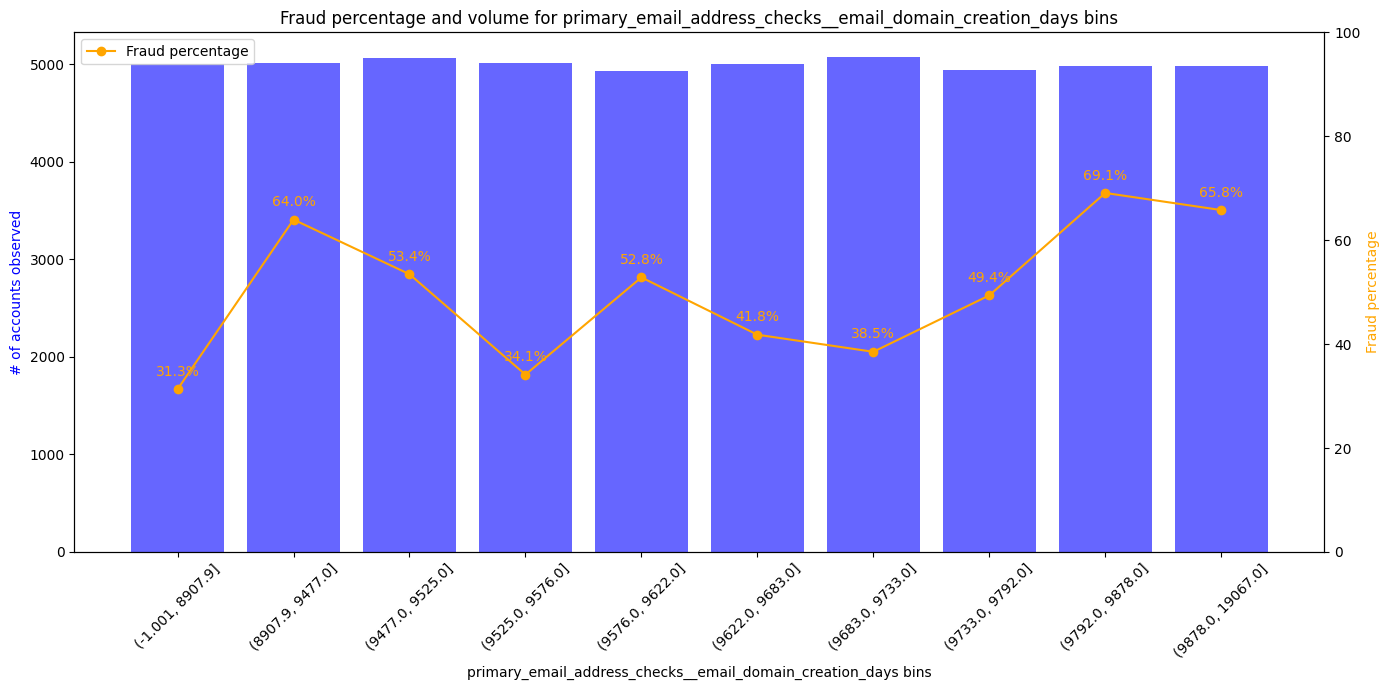

In [34]:
#working with chatgpt to get this ploting function:

def plot_feature_analysis(data, feature):
    unique_values = data[feature].unique()
    if len(unique_values) == 2:
        data[feature] = data[feature].astype(str)

    # Check if the feature is categorical or boolean (now cast to string)
    if data[feature].dtype == 'object' or data[feature].dtype == 'bool':
        # Calculate the volume and fraud percentage for each category
        volume = data[feature].value_counts()
        fraud_percentage = data.groupby(feature)['label'].mean() * 100

        # Plot the data
        fig, ax1 = plt.subplots(figsize=(14, 7))

        # Bar plot for volume
        ax1.bar(volume.index, volume, color='blue', alpha=0.6, label='# of accounts observed')
        ax1.set_xlabel(f'{feature} categories')
        ax1.set_ylabel('# of accounts observed', color='blue')
        ax1.tick_params(axis='x', rotation=45)

        # Line plot for fraud percentage
        ax2 = ax1.twinx()
        ax2.plot(volume.index, fraud_percentage, color='orange', marker='o', label='Fraud percentage')
        ax2.set_ylabel('Fraud percentage', color='orange')
        ax2.set_ylim(0, 100)

        # Add labels and title
        for i, (v, p) in enumerate(zip(volume, fraud_percentage)):
            ax2.text(i, p + 2, f'{p:.1f}%', ha='center', va='bottom', color='orange')  # Adjusted placement

        plt.title(f'Fraud percentage and volume for {feature} categories')
        fig.tight_layout()
        plt.legend(loc='upper left')

        plt.show()
    else:
        # Check if the feature is numeric
        if pd.api.types.is_numeric_dtype(data[feature]):
            # Define bins for numeric features
            bins = 10
            if data[feature].nunique() <= 10:
                bins = data[feature].nunique()

            # Bin the numeric feature with equal population
            binned_feature = pd.qcut(data[feature], q=bins, duplicates='drop')

            # Calculate the volume and fraud percentage for each bin
            volume = data.groupby(binned_feature).size()
            fraud_percentage = data.groupby(binned_feature)['label'].mean() * 100

            # Plot the data
            fig, ax1 = plt.subplots(figsize=(14, 7))

            # Bar plot for volume
            ax1.bar(volume.index.astype(str), volume, color='blue', alpha=0.6, label='# of accounts observed')
            ax1.set_xlabel(f'{feature} bins')
            ax1.set_ylabel('# of accounts observed', color='blue')
            ax1.tick_params(axis='x', rotation=45)

            # Line plot for fraud percentage
            ax2 = ax1.twinx()
            ax2.plot(volume.index.astype(str), fraud_percentage, color='orange', marker='o', label='Fraud percentage')
            ax2.set_ylabel('Fraud percentage', color='orange')
            ax2.set_ylim(0, 100)

            # Add labels and title
            for i, (v, p) in enumerate(zip(volume, fraud_percentage)):
                ax2.text(i, p + 2, f'{p:.1f}%', ha='center', va='bottom', color='orange')  # Adjusted placement

            plt.title(f'Fraud percentage and volume for {feature} bins')
            fig.tight_layout()
            plt.legend(loc='upper left')

            plt.show()

# Iterate through all features and plot
for feature in fraud_train.columns:
    if feature != 'label' and feature != 'fund_id':  # Skip the label column and fund id
        plot_feature_analysis(fraud_train, feature)


## Exercise explanation

a) Given that this is a balanced dataset and assuming the data seen in training will be similar to the data in the real world, accuracy is an appropriate metric for this problem. According to the problem explanation, this accuracy will be used as a threshold so that predictions by the model translate to actual probabilities. Since there was no undersampling or oversampling on my part, the metric remains unbiased.

However, if the model's predictions are to be used for flagging accounts after a certain threshold, it would be essential to discuss with the business the importance of different types of errors. Specifically, I would need to ask whether it is more critical to avoid missing some fraudulent accounts (false negatives) or to minimize falsely marking legitimate accounts as fraudulent (false positives). This information would be crucial for setting the threshold in a way that balances the trade-off between reducing false positives and false negatives.

b)
To answer this question, I would prepare a deck presentation featuring some of the plots I created. Since I am not sure they would understand SHAP values, I believe bivariate plots are a great way of conveying the message. These plots can show how the fraud percentage changes across different groups and highlight the strong relationship between certain features and the target. For the category ID feature, I would emphasize that some categories particularly group fraudulent and non-fraudulent accounts. For the identity check score, I would illustrate the clear, almost linear relationship to fraud detection.

c)
If the dataset were unbalanced, accuracy would no longer be a good metric. In this case, I would choose ROC AUC or F1 score as the metric to optimize and determine the optimal threshold based on business needs. This approach would ensure that the model performs well in identifying fraudulent activities while balancing the trade-offs between different types of errors.

# Exercise 2

In [30]:
#using a transformer despite being more resource intensive because of exercise hint

file_path = input_folder_path + 'recommendations.csv'
df = pd.read_csv(file_path)

#lets use fundname as part of the text for similarity checking
df['text'] = df['fundname'] + " " + df['funddescription']

#Sentence-BERT model
"""
This framework provides an easy method to compute dense vector representations for sentences, paragraphs, and images.
The models are based on transformer networks like BERT / RoBERTa / XLM-RoBERTa etc. and achieve state-of-the-art performance
in various tasks. Text is embedded in vector space such that similar text are closer and can efficiently be found using cosine similarity.

Unlike traditional methods like TF-IDF, which rely on word frequencies, SBERT embeddings capture the semantic meaning of sentences,
making them more effective for understanding and comparing texts based on their content.
"""
model = SentenceTransformer('paraphrase-MiniLM-L6-v2', torch.device('cuda')) #using lightweight version since the original was taking too long
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

df['embedding'] = embeddings.tolist()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

In [31]:
#now that we have the embeddings vectors per fund_id lets compute the cosine distance to each other

similarity_dict = {}
for i, row in df.iterrows():
  fund_id = row['fund_id']
  target_embedding = [row['embedding']]
  if fund_id in [68223259, 65452297, 66816915, 66983771, 67955291, 66967743, 69194379]:
    #only for the requested ids, iterate and calculate distance to all else ids
    similarity_dict_for_id = {}
    for j, row_2 in df.iterrows():
      fund_id_2 = row_2['fund_id']
      target_embedding_2 = [row_2['embedding']]
      if fund_id_2 != fund_id:
        similarities = cosine_similarity(target_embedding, target_embedding_2)[0][0]
        similarity_dict_for_id[fund_id_2] = similarities
    # for the id order, order by the cosine values and get the 5 highest ids/distance values
    sorted_similarity_dict_for_id = dict(sorted(similarity_dict_for_id.items(), key=lambda item: item[1], reverse=True))
    similarity_dict[fund_id] = dict(list(sorted_similarity_dict_for_id.items())[:5]) #keep highest 5



In [32]:
#best 5 best id matches
result = {k: list(v.keys()) for k, v in similarity_dict.items()}
result

{66983771: [63417985, 62402223, 69353283, 68492345, 68074111],
 66967743: [68538995, 64710419, 65275163, 63250167, 64973847],
 67955291: [64404087, 65458371, 69938389, 69128287, 68645027],
 69194379: [63062079, 64940229, 62753907, 67684649, 68188551],
 68223259: [62489355, 62969331, 68045127, 69743839, 64765099],
 65452297: [63938471, 69787433, 62096553, 63206603, 67281327],
 66816915: [68529941, 62377145, 64684189, 63355459, 69307341]}

## Exercise explanation

Given the hint on part b and some research, I decided to use a BERT transformer to be able to transform description into a vector space in which I could meassure distance with each other.

The way to meassure distance I chose was cosine similarity. Basically what this returns (if we think it in a 2 dimensional space) is the cosine of the angle between 2 vectors. The higher the cosine of the angle the 'closer' both vectors are, which means the higher the cosine returned, the more similar 2 vectors are.

In this case since each vector space is a representation of the description text high cosine distance would mean texts are similar.

To get the best 5 matches for each id requested in the exercise I step on each of this ids and iterated thorugh the entire dataset to get the cosine distance for all, store each in a dict, shuffle the values from higher to lower and keep the 5 ids for the largest values.

This would get complex really fast if the exercise tried to match each description to the 5 best, my solution would probably change.

# Exercise 3

In [3]:
file_path = input_folder_path + 'bonus.csv'
data = pd.read_csv(file_path)

nltk.download('stopwords')
nltk.download('punkt')

nlp = spacy.load('en_core_web_sm')
def clean_text(text):
    #remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Use Spacy to remove people's names
    doc = nlp(text)
    text = ' '.join([token.text for token in doc if token.ent_type_ != 'PERSON'])

    #remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)

    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english')).union(set(stopwords.words('spanish')))
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in stop_words])

    return text

data['cleaned_description'] = data['funddescription'].apply(clean_text)

# Display the first few cleaned descriptions
data[['funddescription', 'cleaned_description']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,funddescription,cleaned_description
0,The mission of RememberAVet.net is to secure d...,mission rememberavet net secure donations rais...
1,"\n<div>Hi everyone! My name is Zack Kauffman, ...",hi everyone name recent graduate university ma...
2,"<font color=""#333333"">We have been blessed to ...",blessed working epsilon phi since 1983 hard be...
3,\n<div>My name is Tiffanee Miller. I wanted to...,name wanted start gofundme support family woul...
4,\n<div>Cpl. (Ret.) Cort is a Marine Corps comb...,cpl ret cort marine corps combat veteran lost ...


In [26]:
hdbscan_model = HDBSCAN(min_cluster_size=3)

model = BERTopic(verbose=True, embedding_model='paraphrase-mpnet-base-v2', hdbscan_model=hdbscan_model)

description_topics, _ = model.fit_transform(data.cleaned_description)


2024-07-31 11:39:40,716 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

2024-07-31 11:40:25,348 - BERTopic - Embedding - Completed ✓
2024-07-31 11:40:25,351 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-31 11:40:39,087 - BERTopic - Dimensionality - Completed ✓
2024-07-31 11:40:39,090 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-31 11:40:39,216 - BERTopic - Cluster - Completed ✓
2024-07-31 11:40:39,222 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-31 11:40:39,944 - BERTopic - Representation - Completed ✓


In [27]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head(10)

Number of topics: 128


,Topic,Count,Name,Representation,Representative_Docs
0,-1,777,-1_help_family_time_support,"[help, family, time, support, would, know, yea...",[please read hello everyone know lost 11 month...
1,0,227,0_ukraine_ukrainian_war_refugees,"[ukraine, ukrainian, war, refugees, poland, ru...",[dear friends would like help people ukraine s...
2,1,171,1_loved_family_loss_passed,"[loved, family, loss, passed, passing, funeral...",[world lost amazing mother wife sister neighbo...
3,2,93,2_cancer_treatment_diagnosed_chemo,"[cancer, treatment, diagnosed, chemo, stage, t...",[37 year old wife mother 2 daughters ages 7 12...
4,3,68,3_legal_court_lawsuit_case,"[legal, court, lawsuit, case, gps, judge, poli...",[prepubescent children unrestricted access boo...
5,4,52,4_home_rent_move_moving,"[home, rent, move, moving, place, living, pay,...",[hi name met justice work recall late february...
6,5,35,5_custody_court_legal_attorney,"[custody, court, legal, attorney, child, fees,...",[leading expert 40 years fields interpersonal ...
7,6,28,6_restaurant_business_truck_staff,"[restaurant, business, truck, staff, community...",[hi name val extremely hard never asked help a...
8,7,27,7_gianna_yixin_hospital_genesis,"[gianna, yixin, hospital, genesis, baby, littl...",[surgery previous 术前 上次 surgery previous 术中 上次...
9,8,25,8_van_wheelchair_accessible_mehul,"[van, wheelchair, accessible, mehul, amber, ve...",[hi name mom dad raising money get wheelchair ...


In [29]:
a_topic = freq.iloc[0]["Topic"]
model.get_topic(a_topic) # Show the words and their TF-IDF scores

[('help', 0.006599495113414409),
 ('family', 0.005808097791443043),
 ('time', 0.005499153194949287),
 ('support', 0.005200809000728558),
 ('would', 0.0051066723246693015),
 ('know', 0.004977816192638918),
 ('years', 0.0048503106720646635),
 ('thank', 0.004830649133581578),
 ('life', 0.004822034811457542),
 ('home', 0.004809822782365887)]

In [33]:
model.visualize_barchart(top_n_topics=10)


In [31]:
model.visualize_topics()


In [32]:
model.visualize_hierarchy(top_n_topics=10)


## Exercise explanation

I didnt have a lot of time to do the necessary reasearch to get this into a the place I wanted but what I tried here was to clean up the text description (names was a particular problem I fixed at the end  since it came up as topics but GPU time finished and this takes too long to run without one)

BERTopic runs clustering on topics leveraging transformers and TF-IDF  

Next step would be to get some of the clusters that are close in intertopic distance together to reduce the 128 topics returned, which when looking at the intertopic graph, some could perfectly work together.

HDBSCAN is a way of optimizing for the amount of topics by discovering clusters in data. The parameter I passed to it gives retrictions to reduce the amount of topics found. When tested with min_cluster_size = 4 it only returned 4 topics, so the results with 3 made a lot more sense.

There are some other nounces I would need to dive into such as different languages being present which I did not solve for